In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import table

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]

### Опрос перед началом лекции:

https://docs.google.com/forms/d/e/1FAIpQLSdk5qFGHQ-5lgygkSZ_NzLso9ykxohYpHSTVa5opUgxKfO7-w/viewform?usp=sf_link

# План лекции
- задача кластеризации
- основные подходы к решению задачи
- подробнее рассмотрим 
  * Иерархическую кластеризацию (следующая лекция)
  * графовую кластеризацию 
  * DBScan (следующая лекция)
  * K-Means
  * EM-алгоритм
- метрики оценки качества кластеризации
- практические примеры (поиск похожих акций)

# Задача кластеризации

Нужно данные разбить на группы.
Объекты в одной группе должны быть похожи между собой.
Объекты разных групп должны отличаться.

### Упражнения
- Какой формы могут быть кластеры
- Предложите несколько методов кластеризации через минуту напишите их в чат.

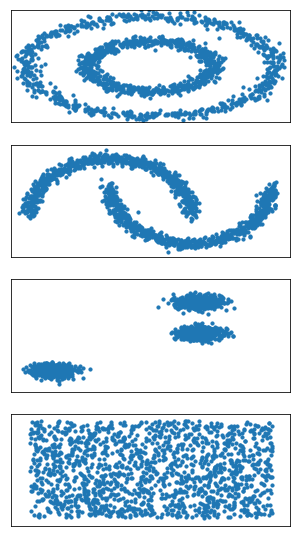

In [3]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

[Hertzsprung–Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram)
![Hertzsprung–Russell diagram](https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png)

### Сложности задачи кластеризации
- задача поставлена некорректно
- существует много различных критериев оценки качества кластеризации
- число кластеров неизвестно заранее и подбирается тяжело
- результаты существенно зависят от метрики

### Цели кластеризации
- упростить дальнейшую обработку данных
- сократить объем хранимых данных (например, bag of clusters)
- выделить шумы (outliers)
- построить иерархию множества объектов (таксономия)


### Виды кластеризации

Automatically created module for IPython interactive environment


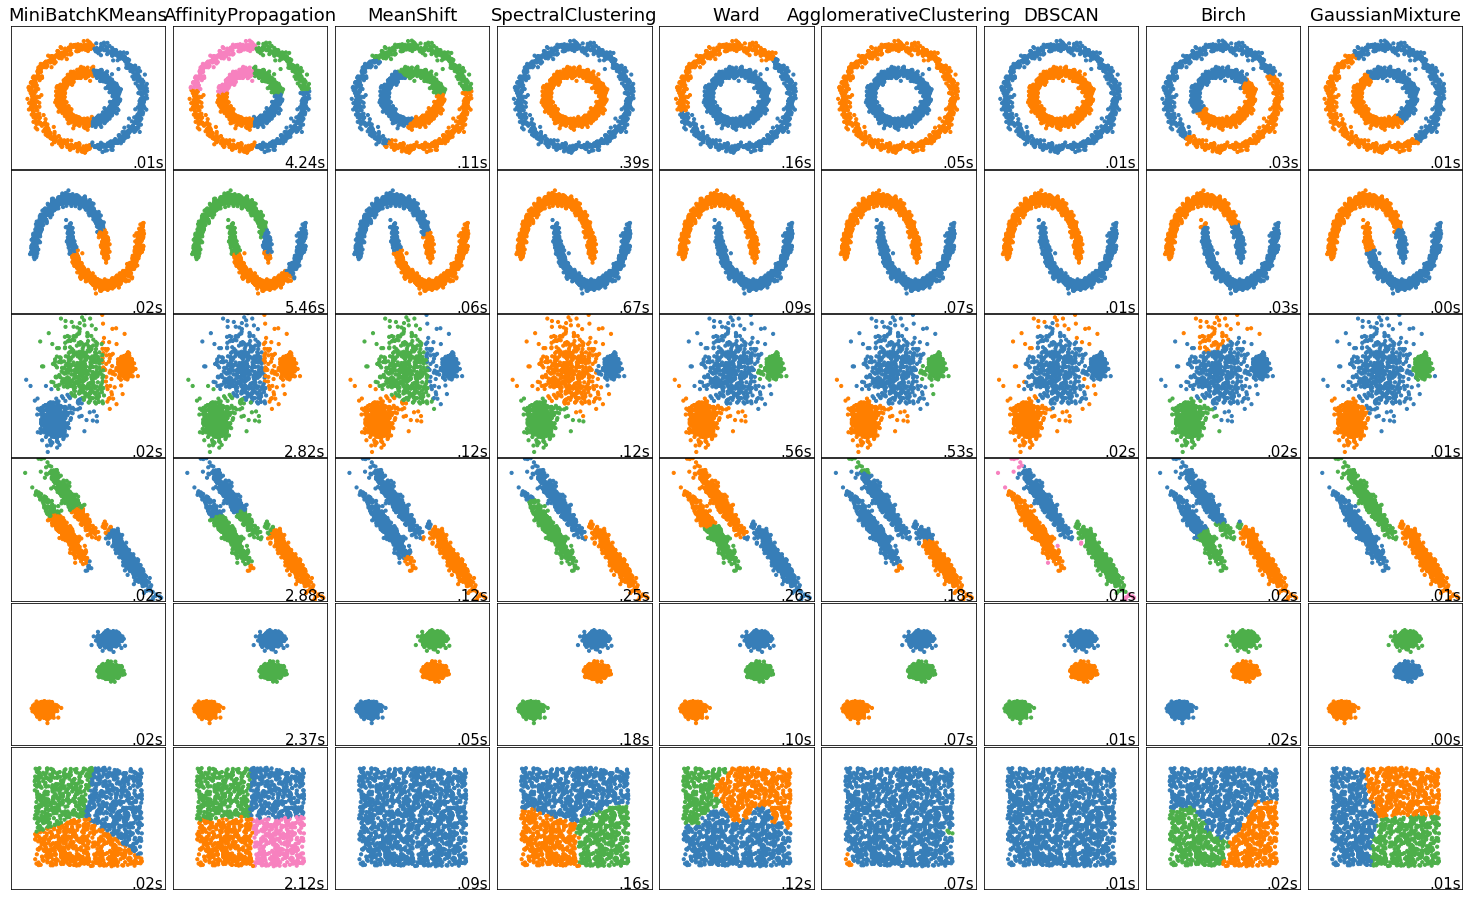

In [4]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### Упражнение
Судя по приведенным примерам, какой алгоритм кластеризации самый лучший?

# Метрики
Краткое напоминание и демонстрация понятия метрики, введеного на лекции о kNN.

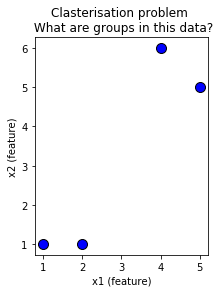

In [5]:
X = np.array([
    [1, 1],
    [2, 1],
    [5, 5],
    [4, 6]
])
plt.scatter(X[:, 0], X[:, 1], c='blue', s=100, edgecolor='black')
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

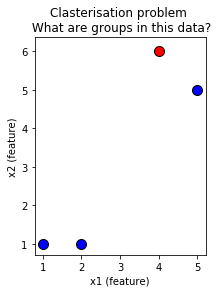

In [6]:
plt.scatter(X[:-1, 0], X[:-1, 1], c='blue', s=100, edgecolor='black')
plt.scatter(X[-1:, 0], X[-1:, 1], c='red', s=100, edgecolor='black')
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

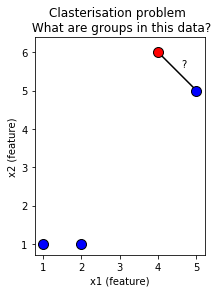

In [7]:
plt.scatter(X[:-1, 0], X[:-1, 1], c='blue', s=100, edgecolor='black', zorder=3)
plt.plot(X[-2:, 0], X[-2:, 1], zorder=2, c='black')
plt.scatter(X[-1:, 0], X[-1:, 1], c='red', s=100, edgecolor='black', zorder=3)
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.text(4.6, 5.6, '?')
plt.gca().set_aspect('equal', adjustable='box')

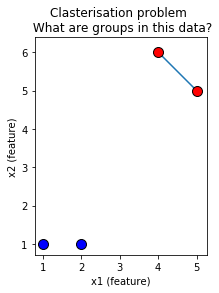

In [8]:
plt.scatter(X[:-2, 0], X[:-2, 1], c='blue', s=100, edgecolor='black')
plt.plot(X[-2:, 0], X[-2:, 1], zorder=2)
plt.scatter(X[-2:, 0], X[-2:, 1], c='red', s=100, edgecolor='black', zorder=3)
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

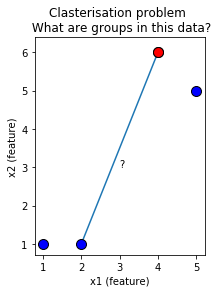

In [9]:
plt.scatter(X[:, 0], X[:, 1], c='blue', s=100, edgecolor='black', zorder=3)
plt.scatter(X[-1:, 0], X[-1:, 1], c='red', s=100, edgecolor='black', zorder=3)
plt.plot(X[1::2, 0], X[1::2, 1], zorder=2)
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.text(3, 3, '?')
plt.gca().set_aspect('equal', adjustable='box')

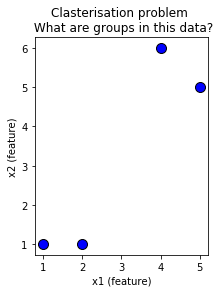

In [13]:
plt.scatter(X[:, 0], X[:, 1], c='blue', s=100, edgecolor='black', zorder=3)
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

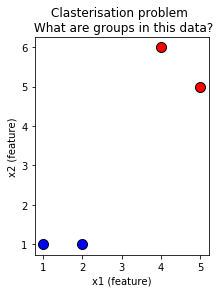

In [14]:
plt.scatter(X[:-2, 0], X[:-2, 1], c='blue', s=100, edgecolor='black')
plt.scatter(X[-2:, 0], X[-2:, 1], c='red', s=100, edgecolor='black')
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

# Меры близости (как посчитать расстояние между объектами - наблюдениями из обучающей выборки?)

* Как определить похожие объекты?

* Необходимо ввести функцию расстояния (не обязательно метрику (?) )

### Количественные признаки

$$ d(a, b) = \sum\limits_{i=1}^{D}(a_i - b_i)^2 \text{: euclidean distance} $$

5.0


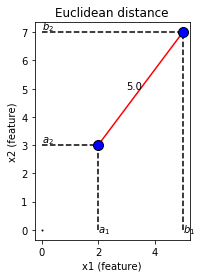

In [10]:
from scipy.spatial import distance
def draw_euclidean():
    X = np.array([
      [0,0],
      [2, 3],
      [5, 7]
    ])
    #calc dist
    dist = distance.euclidean(X[1,:], X[2,:])
    print(dist)
    #preps
    plt.scatter(X[0, 0], X[0, 1],  s=1, edgecolor='black')
    plt.scatter(X[1:, 0], X[1:, 1],zorder=2, c='blue', s=100, edgecolor='black')
    plt.title("Euclidean distance")
    #x-coords
    plt.plot([2,2], [0,3], '--',zorder=1, c='black')
    plt.plot([5,5], [0,7], '--',zorder=1, c='black')
    #y-coords
    plt.plot([0,2], [3,3], '--',zorder=1, c='black')
    plt.plot([0,5], [7,7], '--',zorder=1, c='black')
    #distance
    plt.plot([2,5],[3,7], zorder=1, c='red')

    #labels
    plt.text(0, 3.1, '$a_{2}$')
    plt.text(0, 7.1, '$b_{2}$')
    plt.text(2, -0.1, '$a_{1}$')
    plt.text(5, -0.1, '$b_{1}$')
    plt.text(3, 5, dist)

    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='box')
  
  
draw_euclidean()

$$ d(a, b) = \sum\limits_{i=1}^{D}|a_i - b_i| \text{: manhattan distance} $$

7


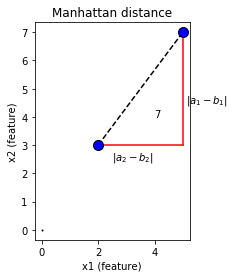

In [11]:
def draw_manhattan():
    X = np.array([
      [0,0],
      [2, 3],
      [5, 7]
    ])
    #calc dist
    dist = distance.cityblock(X[1,:], X[2,:])
    print(dist)
    #preps
    plt.scatter(X[0, 0], X[0, 1],  s=1, edgecolor='black')
    plt.scatter(X[1:, 0], X[1:, 1],zorder=2, c='blue', s=100, edgecolor='black')
    plt.title("Manhattan distance")
    #cathetus
    plt.plot([2,5], [3,3], zorder=1, c='red')
    plt.plot([5,5], [3,7], zorder=1, c='red')

    #distance
    plt.plot([2,5],[3,7],'--', zorder=1, c='black')

    #labels
    plt.text(2.5,2.5, '$|a_{2}-b_{2}|$')
    plt.text(5.1, 4.5, '$|a_{1}-b_{1}|$')
    plt.text(4, 4, dist)

    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='box')
  
  
draw_manhattan()

$$ d(a, b) = \frac{\langle a,b \rangle}{||a||\cdot||b||} \text{: cosine similarity, где} $$
$$||a|| \text{ и } ||b|| \text{ - длины векторов a и b  }$$ 

$$\langle a,b \rangle \text{ - скалярное произведение векторов a и b  }$$ 

0.2697285864811044


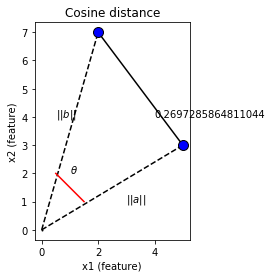

In [12]:
from matplotlib.patches import Arc
def draw_cosine():
    X = np.array([
      [0,0],
      [2, 7],
      [5, 3]
    ])
    #calc dist
    dist = distance.cosine(X[1,:], X[2,:])
    print(dist)
    #preps
    plt.scatter(X[0, 0], X[0, 1],  s=1, edgecolor='black')
    plt.scatter(X[1:, 0], X[1:, 1],zorder=2, c='blue', s=100, edgecolor='black')
    plt.title("Cosine distance")
    #cathetus
    plt.plot([0,2], [0,7],'--', zorder=1, c='black')
    plt.plot([0,5], [0,3],'--', zorder=1, c='black')

    #distance
    plt.plot([2,5],[7,3], zorder=1, c='black')

    #labels
    plt.text(4, 4, dist)
    plt.text(1, 2, '$\\theta$')
    plt.text(3, 1, '$||a||$')
    plt.text(0.5, 4, '$||b||$')

    #angle
    plt.plot([0.5,1.5],[2,1], zorder=1, c='red')
    #   angle = Arc([0,0],1,1,theta1=74.05, theta2=59.04, color="red")
    #   plt.add_patch(angle)


    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='box')
  
  
draw_cosine()

### Упражнение с прошлого раза
Как посчитать близость между 
- текстами (для рекомендаций текстов)
- профилями людей в социальной сети (определение машенников)

In [19]:
def calc_hamming():
    A = np.array([1, 0, 1, 0])
    B = np.array([1, 1, 0, 1])
    dist = distance.hamming(A,B)
    print(dist)
  
calc_hamming()

0.75


### Близость на множествах
* Пусть объект описывается набором категорий, слов, тегов
    * A: {a, b, c, d}
    * B: {a, e, f, c, g}
* Расстояние Джакарда - Jaccard distance:
$$d(a,b) = 1 - \frac{|a \cap b|}{|a \cup b|}$$

$$d(a,b) = 1 - \frac{2}{7} = \frac{5}{7} $$

In [13]:
def calc_jaccard():
    #onehot encoding of classes a,b,c,d,e,f,g
    A = np.array([1, 1, 1, 1, 0, 0, 0])
    B = np.array([1, 0, 1, 0, 1, 1, 1])
    dist = distance.jaccard(A,B)
    print(dist)
calc_jaccard()

0.7142857142857143


### Расстояние на строках
* Расстояние Левенштейна

Количество операций вставки $(I)$, удаления $(D)$ и замены $(R)$, которое необходимо сделать, чтобы получить из строки $S_1$ строку $S_2$.

### Упражнение
В каких задачах полезно использовать расстояние Левенштейна

### Виды кластеризации
- иерархическая кластеризация
  * агломеративная (объединительная)
  * иерархическая
- статистические методы
  * k-means
  * EM-алгоритм
- методы на основе теории графов
- нечеткие алгоритмы

Отдельно выделяют виды кластеризации:
- soft clustering (возвращается распределение)
- hard clustering (присваиваются классы)

### Soft clustering

X:
[[1 1]
 [2 1]
 [5 5]
 [4 6]]
y:
[[0.99 0.01]
 [0.98 0.02]
 [0.03 0.97]
 [0.04 0.96]]


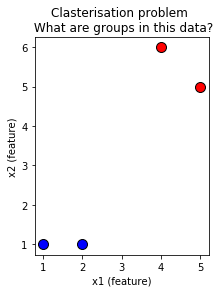

In [14]:
plt.scatter(X[:-2, 0], X[:-2, 1], c='blue', s=100, edgecolor='black')
plt.scatter(X[-2:, 0], X[-2:, 1], c='red', s=100, edgecolor='black')
plt.title("Clasterisation problem \n What are groups in this data?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

y = np.array([
    [0.99, 0.01],
    [0.98, 0.02],
    [0.03, 0.97],
    [0.04, 0.96],
])
print('X:')
print(X)
print('y:')
print(y)

### Hard clustering

In [15]:
y = np.array([0, 0, 1, 1])
print('X:')
print(X)
print('y:')
print(y)

X:
[[1 1]
 [2 1]
 [5 5]
 [4 6]]
y:
[0 0 1 1]


# Иерархическая кластеризация

подробно будет обсуждаться на следующей лекции

![Linguistic Family Tree](http://images.mentalfloss.com/sites/default/files/196.jpg) 

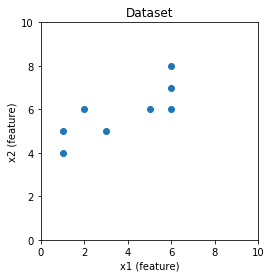

In [16]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([
    [3, 1, 1, 2, 6, 6, 6, 5],
    [5, 4, 5, 6, 8, 6, 7, 6]
]).T

plt.scatter(X[:,0], X[:,1])
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

Все элементы - сами себе кластеры.
Найдем два ближайших

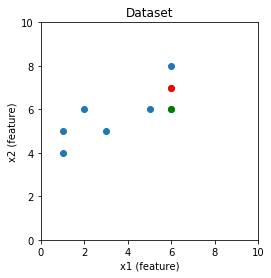

In [17]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='g')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

Эти два кластера объединяются в один

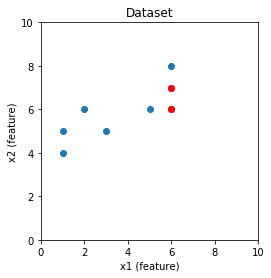

In [18]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='r')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

В дальнейшем мы будем искать пары близлежащих кластеров, не забывая при этом, что свежеобразованные кластеры участвуют в следующем разбиении вместо двух своих "родителей".

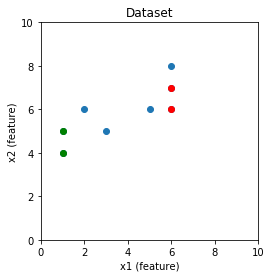

In [19]:
plt.scatter(X[:,0], X[:,1])
#first
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='r')
#second
plt.scatter(X[1,0], X[1,1], c='g')
plt.scatter(X[2,0], X[2,1], c='g')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")

plt.gca().set_aspect('equal', adjustable='box')

Каждый шаг разбиения сокращает количество кластеров на один.

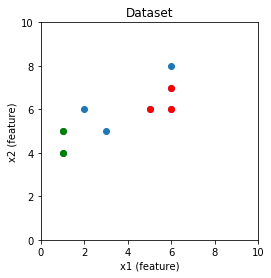

In [20]:
# X = np.array([
#     [3, 1, 1, 2, 6, 6, 6, 5],
#     [5, 4, 5, 6, 8, 6, 7, 6]
# ]).T
plt.scatter(X[:,0], X[:,1])
#first
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='r')
plt.scatter(X[7,0], X[7,1], c='r')
#second
plt.scatter(X[1,0], X[1,1], c='g')
plt.scatter(X[2,0], X[2,1], c='g')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

В итоге мы хотим свести все разбиение к одному большому кластеру. Этот подход называется "снизу вверх" или агломеративный (объединяющий).

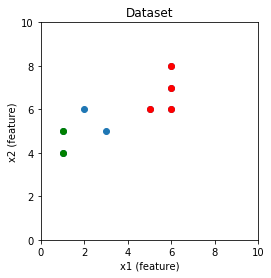

In [21]:
plt.scatter(X[:,0], X[:,1])
#first
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='r')
plt.scatter(X[7,0], X[7,1], c='r')
plt.scatter(X[4,0], X[4,1], c='r')
#second
plt.scatter(X[1,0], X[1,1], c='g')
plt.scatter(X[2,0], X[2,1], c='g')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

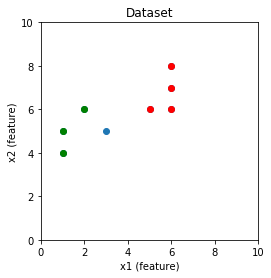

In [52]:
plt.scatter(X[:,0], X[:,1])
#first
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='r')
plt.scatter(X[7,0], X[7,1], c='r')
plt.scatter(X[4,0], X[4,1], c='r')
#second
plt.scatter(X[1,0], X[1,1], c='g')
plt.scatter(X[2,0], X[2,1], c='g')
plt.scatter(X[3,0], X[3,1], c='g')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

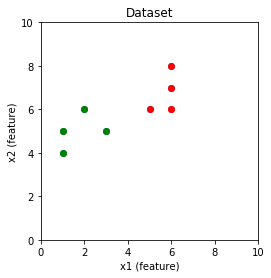

In [22]:
plt.scatter(X[:,0], X[:,1])
#first
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='r')
plt.scatter(X[7,0], X[7,1], c='r')
plt.scatter(X[4,0], X[4,1], c='r')
#second
plt.scatter(X[1,0], X[1,1], c='g')
plt.scatter(X[2,0], X[2,1], c='g')
plt.scatter(X[3,0], X[3,1], c='g')
plt.scatter(X[0,0], X[0,1], c='g')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

Как мы видим, перед финальным шагом у нас имеется два кластера, которые в итоге объединятся в один "корневой"

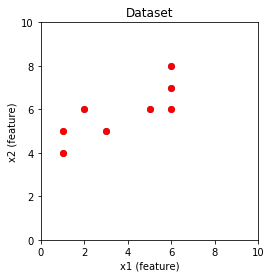

In [23]:
# X = np.array([
#     [3, 1, 1, 2, 6, 6, 6, 5],
#     [5, 4, 5, 6, 8, 6, 7, 6]
# ]).T
plt.scatter(X[:,0], X[:,1])
#first
plt.scatter(X[6,0], X[6,1], c='r')
plt.scatter(X[5,0], X[5,1], c='r')
plt.scatter(X[7,0], X[7,1], c='r')
plt.scatter(X[4,0], X[4,1], c='r')
#second
plt.scatter(X[1,0], X[1,1], c='r')
plt.scatter(X[2,0], X[2,1], c='r')
plt.scatter(X[3,0], X[3,1], c='r')
plt.scatter(X[0,0], X[0,1], c='r')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

Если пройти все шаги разбиения в обратном порядке можно построить дерево разбиения, в нашем случае оно будет выглядеть следующим образом:

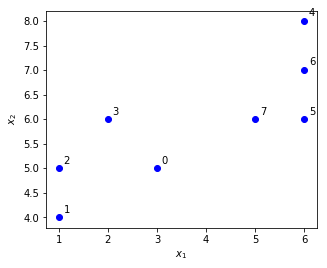

In [24]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='centroid', metric='euclidean')

plt.scatter(X[:,0], X[:,1], c='blue')
for idx, row in enumerate(X):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gca().set_aspect('equal', adjustable='box')

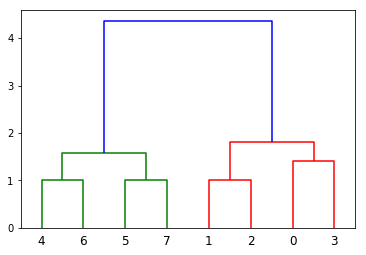

In [25]:
fig, ax = plt.subplots(1, 1)
dend = dendrogram(Z, ax=ax, truncate_mode='lastp') 

### Виды расстояний между кластерами

**single-linkage**

$$d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}'\|$$

**complete-linkage**

$$d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \|$$

**average linkage**

$$d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \|$$


**centroid linkage**
$$d_{mean}(C_i, C_j) = \|\mathbf{m}_i -\mathbf{m}_j \| $$

# Графовые алгоритмы кластеризации

https://www.slideshare.net/ssakpi/graph-based-clustering

* Нарисуем полный граф с весами, равными расстоянию между объектами.
* Выберем лимит расстояния r и выбросим все рёбра длиннее r.
* Компоненты связности полученного графа — это наши кластеры.

Оптимизация:
* Построить минимальное остовное дерево, а потом выкидывать из него рёбра максимального веса. (см. Алгоритмы Прима, Крускала и Борувки)
* Сколько рёбер выбросим, столько кластеров получим.

# Алгоритм k-means
* Выбрать количество кластеров k, которое нам кажется оптимальным для наших данных.
* Выбрать случайным образом k точек (центроидов)
* Для каждой точки определить, к какому центроиду она ближе.
* Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
* Повторять последние два шага или $n\_iter$ число раз, или когда кластеры сойдутся.

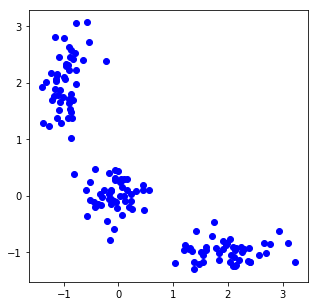

In [26]:
# Начнём с того, что насыпем на плоскость три кластера точек
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [27]:
# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

# Прибьём рандомность и насыпем три случайные центроиды для начала
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

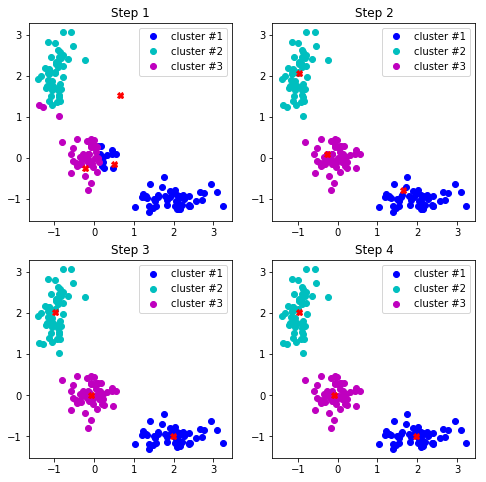

In [28]:
# А теперь нарисуем всю эту красоту
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

## Методы подбора $K$
- бизнес требования
- инерция 
$$J(C) = \sum_k \sum_i {||x_i - \mu_k ||^2} -> \min_C$$
Когда $J(C)$ начинает изменяться не так быстро, мы нашли оптимальное K.

$$D(k) = \frac{|J(C_k) - J(C_{k + 1})|}{|J(C_k - 1) - J(C_k)|}$$

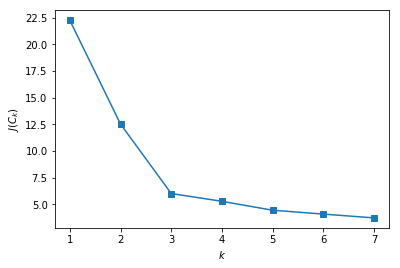

In [30]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## DBScan

[Визуализация алгоритма](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

* Кластеризация, основанная на плотности объектов
* Кластеры – участки высокой плотности, разделенные участками низкой
плотности
* жадный алгоритм

#### Определения

**Плотность**  
Количество объектов внутри сферы заданного радиуса $\varepsilon$

**Core-объект**  
Объект $\mathbf{x}$ является core-объектом, если плотность вокруг него больше $min\_pts$

**Граничный-объект**  
Объект $\mathbf{x}$ является граничным-объектом, если плотность вокруг него меньше $min\_pts$, но он находится внутри сферы заданного радиуса вместе с хотя бы одним core-объектом

**Шум**  
Объект $\mathbf{x}$ является шумом, если он не является ни core-объектом, ни граничным объектом

#### Параметры алгоритма
$min\_pts$, $\varepsilon$

![alt text](https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg)

```
function dbscan(X, eps, min_pts):
	initialize NV = X # not visited objects
	for x in NV:
		remove(NV, x) # mark as visited
		nbr = neighbours(x, eps) # set of neighbours
		if nbr.size < min_pts:
			mark_as_noise(x)
		else:
			C = new_cluster()
			expand_cluster(x, nbr, C, eps, min_pts, NV)
			yield C
```


```


function expand_cluster(x, nbr, C, eps, min_pts, NV):
	add(x, C)
	for x1 in nbr:
		if x1 in NV: # object not visited
			remove(NV, x1) # mark as visited
			nbr1 = neighbours(x1, eps)
			if nbr1.size >= min_pts:
				# join sets of neighbours
				merge(nbr, nbr_1)
		if x1 not in any cluster:
			add(x1, C)
```




[Подбор параметров в DBScan](http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)


**Сложность**: $O(n^2)$ или $O(n \log n)$ ($R^*Tree$) \\
**Память**: $O(n)$ или $O(n^2)$

* не требует $K$
* кластеры произвольной формы
* учитывает выбросы
* Не вполне детерминированный
* Не работает при разных плотностях кластеров (см. Optics)

## EM-кластеризация

## Гипотеза о вероятностной природе данных
Выборка $X^l$ случайна, независима, из смеси распределений 
$$p(x) = \sum_y w_y p_y(x)$$
$$\sum_y w_y = 1$$

## Гипотеза о пространстве объектов и форме кластеров

$$X = R^n$$
$$ p_y(x) = (2 * \pi)^{\frac{-n}{2}} (\sigma_{y1} ... \sigma_{yn}) ^ {-1} exp(\frac{-1}{2}\rho_y^2(x, \mu_y))$$

Центры кластеров: $$\mu_y = (\mu_{y1}, ..., \mu_{yn})$$
Диагональная матрица ковариаций: $$\Sigma_y = diag(\sigma_{y1}, ..., \sigma_{yn})$$

$$\rho_y^2(x, x') = \sum_{j}\sigma_{yj}^{-2} |f_j(x) - f_j(x')|$$

EM-алгоритм:
1. задать начальное приближение для $w_y, \mu_y, \Sigma_y$
2. E-шаг:
$$ g_{iy} = P(x | x_i) = \frac{w_y p_y(x)}{\sum_z {w_z p_z(x_i)}}$$
3. M-шаг:
$$w_y = \frac{1}{l}\sum_i g_{iy}$$
$$\mu_{yj} = \frac{1}{lw_y} \sum_i g_iy f_j(x_i)$$
$$\sigma = ....$$
$$ y_i = \arg \max_y (g_{iy}) $$

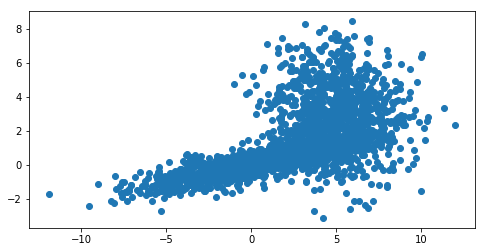

In [36]:
np.random.seed(0)
n_samples = 1000
X1 = 2.0*np.random.randn(n_samples, 2) + np.array([5, 3])
C = np.array([[0., -0.5], [3.5, .7]])
X2 = np.dot(np.random.randn(n_samples, 2), C)
X_train = np.vstack([X1, X2])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train[:,0], X_train[:,1], 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [37]:
from sklearn.mixture import GMM

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an

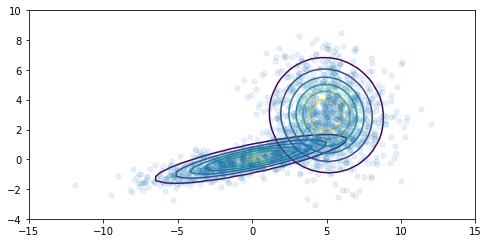

In [38]:
np.random.seed(1)
model = GMM(n_components=2, covariance_type='full')
model.fit(X_train)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train[:,0], X_train[:,1], 'o', alpha=.1, ms=5)

for i in range(2):    
    mu = model.means_[i]
    sigma = model.covars_[i]
    sigma_inv = np.linalg.inv(sigma)
    sigma_det = np.linalg.det(sigma)
    x = np.linspace(-15.0, 15.0)
    y = np.linspace(-4.0, 10.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    XX = np.dot(np.dot(XX - mu, sigma_inv), 
                np.transpose(XX - mu))
    P = np.exp(-0.5*np.diagonal(XX))/(2*np.pi*sigma_det**0.5)
    P = P.reshape(X.shape)
    CS = plt.contour(X, Y, P)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [39]:
def Estep(mu, sigma, phi):
    # calculate determinants of sigma's
    det_sigma = np.array([[np.linalg.det(sigma[i])] 
                          for i in range(k)])
    # calculate inverse matrices for sigma's
    inv_sigma = np.array([np.linalg.inv(sigma[i]) 
                          for i in range(k)]).reshape(sigma.shape)
    # calculate Q(z) = p(x|z)*p(z)/p(x)
    pxz = np.array([
            np.exp(
                -0.5*np.diagonal(
                    np.dot(
                        np.dot(X_train - mu[i,:], inv_sigma[i]), 
                        np.transpose(X_train - mu[i,:])
                    )
                )
            )/((2.0*np.pi)**(n/2.0)*det_sigma[i,0]**0.5)*phi[i,0] 
            for i in range(k)]).T
    pz = pxz/np.sum(pxz, axis=1).reshape((-1, 1))
    return pz

def Mstep(pz):
    pz_sum = np.sum(pz, axis=0).reshape((-1,1))
    # update parameters
    phi_new = pz_sum/m
    mu_new = np.transpose(np.dot(X_train.T, pz)/pz_sum.T)
    sigma_new = np.array([
            np.dot(np.array([
                        np.outer(X_train[j,:] - mu_new[i,:], 
                                 X_train[j,:] - mu_new[i,:]) 
                        for j in range(m)]).reshape((m, -1)).T, 
                   pz[:,i]).reshape((n,n))/pz_sum[i,0] 
            for i in range(k)]).reshape((k,n,n))
    return mu_new, sigma_new, phi_new

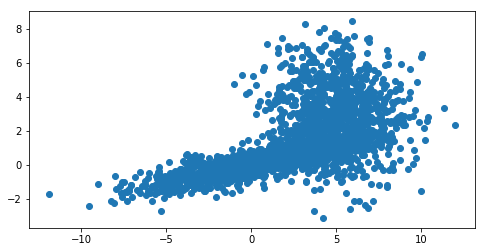

In [40]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train[:,0], X_train[:,1], 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [42]:
# number of components
k = 2
# number of features
n = X_train.shape[1]
# number of training examples
m = X_train.shape[0]
# number of iterations
niter = 10
# initial values of phi
phi = np.array([1.0/k]*k).reshape((k,-1))
# initial values for mu and sigma
mu = []
sigma = []
np.random.seed(234)
for cl in range(k):
    mu.append(np.mean(X_train[np.random.choice(m, m//2),:], axis=0))
    sigma.append(np.identity(n))
mu = np.array(mu).reshape((k, n))
sigma = np.array(sigma).reshape((k, n, n))

In [22]:
for nit in range(niter):
    print('Iteration ' + str(nit+1) + ':')
    pz = Estep(mu, sigma, phi)
    mu, sigma, phi = Mstep(pz)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(X_train[:,0], X_train[:,1], 'o', alpha=.1, ms=5)
    for i in range(k):    
        mu_i = mu[i,:]
        sigma_i = sigma[i]
        sigma_i_inv = np.linalg.inv(sigma_i)
        x = np.linspace(-15.0, 15.0)
        y = np.linspace(-4.0, 10.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        P = np.exp(-0.5*np.diagonal(
                np.dot(
                    np.dot(XX - mu_i, sigma_i_inv), 
                    np.transpose(XX - mu_i)
                )))/(2*np.pi*np.linalg.det(sigma_i)**0.5)
        P = P.reshape(X.shape)
        CS = plt.contour(X, Y, P)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

NameError: name 'niter' is not defined

## Упражнение:
Что является E-шагом и M-шагом в K-Means?


### GMM может использоваться также для генерации новых данных

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

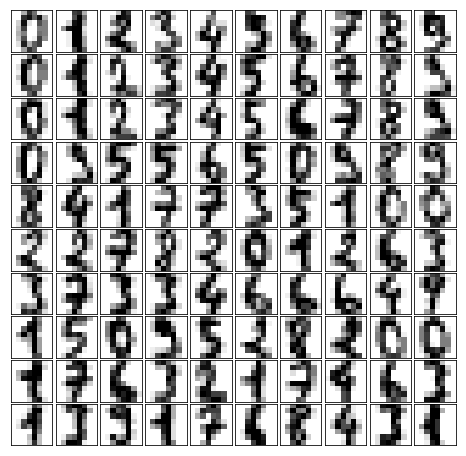

In [15]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [16]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/depreca

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projec

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projec

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projec

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Dep

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projec

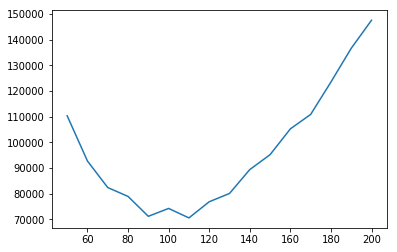

In [18]:
from sklearn.mixture import GMM

n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [19]:
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/an

True


/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [20]:
data_new = gmm.sample(100, random_state=0)
data_new.shape

(100, 41)

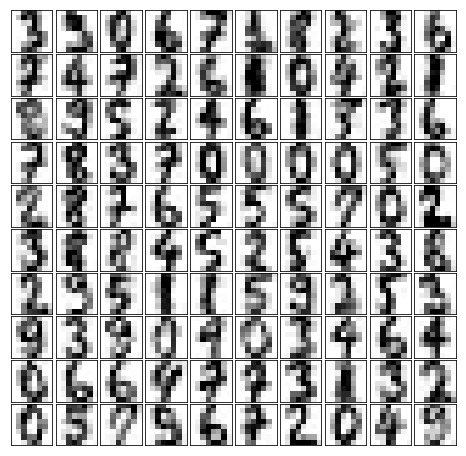

In [21]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

# Оценка качества кластеризации

### Упражнение
Предположим мы построили кластеризацию, как оценить качество?
В этом вопросе важно придумать не численную формулу, а сказать, что такое "хорошая кластеризация"

## Критерии качества (без использования дополнительной информации)
* инерция - средняя сумма квадратов расстояния до центроида
* средний диаметр кластера
* максимальный диаметр кластера
* силуэт
* SSE(sum of the square error from the items of each cluster)
* расстояния внутри кластера
* расстояние между кластерами


Пусть дана кластеризация в $K$ кластеров, и объект $i$ попал в $C_k$  
$a(i)$ -- среднее расстояние от $i$ объекта до объектов из $C_k$  
$b(i) = min_{j \neq k} b_j(i)$,  где $b_j(i)$ -- среднее расстояние от $i$ объекта до объектов из $C_j$

$$silhouette(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$
Средний silhouette для всех точек из $\mathbf{X}$ является критерием качества кластеризации.

Показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. 

Принимает значения $[−1,1]$. 
$-1$ - плохая (разрозненная) кластеризация.  
$0$ - кластеры пересекаются и накладываются друг на друга  
$1$ - "плотные" четко выделенные кластера  
Чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.


## Критерии качества с использованием дополнительной информации
* Adjusted Rand Index (ARI) (https://en.wikipedia.org/wiki/Rand_index)
* Adjusted Mutual Information (AMI)

# Практический пример

### Поиск похожих акций

- хотим кластеризовать компании
- предсказывать стоимость акции компании по акциям других компаний из кластера

In [2]:
import pandas as pd

fn = 'data/stocks.csv'
stocks_df = pd.read_csv(fn, index_col=0)

In [3]:
companies = list(stocks_df.index)
movements = stocks_df.values

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

normalizer = Normalizer()
kmeans = KMeans(n_clusters=14)
pipeline = make_pipeline(normalizer, kmeans)
pipeline.fit(movements)

Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [5]:
labels = pipeline.predict(movements)

In [6]:
df = pd.DataFrame({'labels': labels, 'companies': companies})

In [11]:
df.sort_values('labels')

,labels,companies
22,0,HP
14,0,Dell
20,1,Home Depot
16,1,General Electrics
58,1,Xerox
0,2,Apple
33,2,Microsoft
23,2,IBM
42,2,Royal Dutch Shell
17,2,Google/Alphabet


### Упражнения:
- проделать тоже самое для рынка российских акций
- попробовать иерархическую кластеризацию для рынка акций (что значат мелкие кластеры)
- попробовать реализовать графовый алгоритм кластеризации

### Опрос в конце лекции

https://docs.google.com/forms/d/e/1FAIpQLSdHO_3Gxprqp94ASRRWbgTU4uk-JtvTuK2UEaSkmtKXBzjgKg/viewform?usp=sf_link

### Дополнительные материалы
[Слайды лекции С.Николенко по кластеризации](https://logic.pdmi.ras.ru/~sergey/teaching/mlau12/10-clustem.pdf)

[DBScan](https://habrahabr.ru/post/322034/)  

[Обзор алгоритмов в sklearn](http://scikit-learn.org/stable/modules/clustering.html)

http://www.jmlr.org/papers/volume5/dy04a/dy04a.pdf 

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

http://www.ccas.ru/voron/download/Clustering.pdf

http://www.machinelearning.ru/wiki/images/archive/2/28/20150427184336%21Voron-ML-Clustering-slides.pdf

[Сети Кохонена](http://www.machinelearning.ru/wiki/index.php?title=Нейронная_сеть_Кохонена)

### Фидбек:
https://otus.ru/polls/1881/